In [ ]:
%pip install qujax

In [ ]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np

# Generative Modeling

In [ ]:
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
beta = 1e3
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 5000
random_key = random.PRNGKey(0)

In [ ]:
init_key, train_key = random.split(random_key)

In [ ]:
with open("hidalgo_stamp.txt", "r") as f:
    all_lines = [line[:-1].rstrip().split(" ") for line in f if line != "\n"]
data = jnp.hstack([[float(a) for a in line] for line in all_lines]) * 1000
data = jnp.array(data, dtype=int)
#data = jax.random.exponential(jax.random.PRNGKey(0), (10000,)) * 1. + 0.
#data = jnp.array(data, dtype='float64')

In [ ]:
import numpy as np

def sample_f(a, d, n_sample):
    coin = np.random.binomial(1, 0.5, n_sample) * 2. - 1.
    return np.outer(coin, a) + np.random.randn(n_sample, d)

a = np.ones(2) * 2
a[1] = 0
data = sample_f(a, 2, 2000) + 10
data = jax.device_put(data @ a.T)

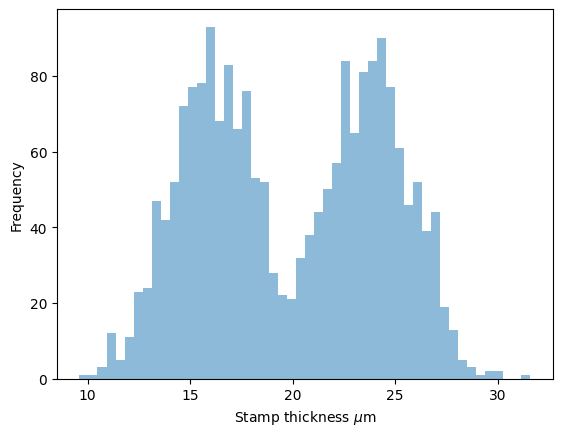

In [ ]:
plt.hist(data, bins=50, alpha=0.5)
plt.ylabel("Frequency")
plt.xlabel("Stamp thickness $\\mu$m");

In [ ]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()

def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

In [ ]:
gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=48);

q0: -----H-----Rx[0]---Ry[8]-----◯---------------------------------------------Rx[16]--Ry[24]------------◯-----------
                                 |                                                                       |           
q1: -----H-----Rx[1]---Ry[9]-----CZ------◯-------------------------------------Rx[17]--Ry[25]------------CZ------◯---
                                         |                                                                       |   
q2: -----H-----Rx[2]---Ry[10]------------CZ------◯-----------------------------Rx[18]--Ry[26]--------------------CZ--
                                                 |                                                                   
q3: -----H-----Rx[3]---Ry[11]--------------------CZ------◯---------------------Rx[19]--Ry[27]------------------------
                                                         |                                                           
q4: -----H-----Rx[4]---Ry[12]---------------------------

In [ ]:
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
bandwidth_sq = jnp.median(dist_mat) / 2


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(jnp.linalg.norm(s1 - s2)) / bandwidth_sq)

data_probs = jnp.ones(len(data)) / len(data)

def param_to_mmd(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

NameError: name 'qujax' is not defined

# SGNHT

In [ ]:
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)
train_keys = random.split(train_key, n_steps - 1)
params = jnp.zeros((n_steps, n_params))
params = params.at[0].set(init_param)

cost_vals = jnp.zeros(n_steps - 1)

In [ ]:
M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.

def G(p):
  return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h):
  q = q + h * M_inv @ p
  return q,p,xi

def B_step(q,p,xi,h,force):
  p = p + h * (force(q) + sigma * np.sqrt(M) @ np.random.randn(p.shape[0]))
  return q,p,xi

def O_step(q,p,xi,h):
  term1 = np.exp(-xi*h) * p
  term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
  p = term1 + term2
  return q,p,xi

def D_step(q,p,xi,h):
  xi = xi + h * G(p)
  return q,p,xi

def ld_BADODAB(q,p,xi,h,force):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = O_step(q,p,xi,h)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = B_step(q,p,xi,h/2,force)

    return q, p, xi

def run_simulation(q0, p0, xi0, Nsteps, h, step_function, force):

    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0

    for n in range(Nsteps):
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])
        q,p,xi = step_function(q, p, xi, h, force)
        cost_vals.append(cost_val)

        q_traj += [q]
        p_traj += [p]
        xi_traj += [xi]

    return q_traj, p_traj, xi_traj, cost_vals

In [ ]:
params, p_traj, xi_traj, cost_vals = run_simulation(params[0], np.random.randn(n_params), 0.0, n_steps, 0.1, ld_BADODAB, lambda q: -param_to_mmd_and_grad(q)[1])

Text(0, 0.5, 'MMD')

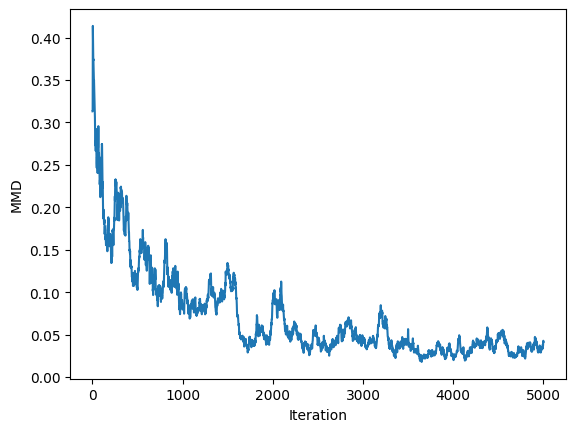

In [ ]:
plt.plot(np.arange(1,n_steps + 1), cost_vals)
plt.xlabel("Iteration")
plt.ylabel("MMD")

# Plot

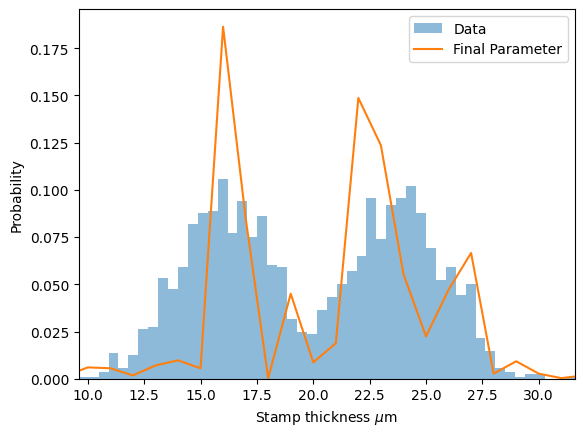

In [ ]:
final_params = params[np.argmin(cost_vals)]
final_st = param_to_st(final_params)

plt.hist(data, bins=50, density=True, alpha=0.5, label="Data")
plt.plot(jnp.square(jnp.abs(final_st.flatten())), label="Final Parameter")
plt.xlim(data.min(), data.max())
plt.ylabel("Probability")
plt.xlabel("Stamp thickness $\\mu$m")
plt.legend();

In [ ]:
burn_in = 100
av_probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(
    params[burn_in:]
).mean(0)

plt.plot(av_probs, label="Averaged over parameters")
plt.xlim(data.min(), data.max())
plt.ylabel("Probability")
plt.xlabel("Stamp thickness $\\mu$m")
plt.legend();